In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import enum
import numpy as np
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist


In [99]:
class CellType(enum.IntEnum):
    HSC = 0
    MPP1 = 1
    MPP2 = 2
    MPP3 = 3
    MPP4 = 4
    MPP5 = 5
    CMP = 6
    CLP = 7
    MEP = 8
    GMP = 9
    Erythroblast1 = 10
    Erythroblast2 = 11
    Erythroblast3 = 12
    Erythroblast4 = 13
    Erythroblast5 = 14
    Erythroblast6 = 15
    Erythroblast7 = 16
    Erythroblast8 = 17
    RBC = 18
    Myeloblast1 = 19
    Myeloblast2 = 20
    Myeloblast3 = 21
    Myeloblast4 = 22
    Myeloblast5 = 23
    Myeloblast6 = 24
    Myeloblast7 = 25
    Myeloid = 26
    Megakaryocyte = 27
    Platelet = 28
    Lymphocyte1 = 29
    Lymphocyte2 = 30
    Lymphocyte3 = 31
    Lymphocyte4 = 32
    Lymphocyte5 = 33
    Lymphocyte6 = 34
    Lymphocyte7 = 35
    Lymphocyte8 = 36
    Lymphocyte9 = 37
    Lymphocyte10 = 38
    Bcell = 39
    STROMA = 40

HSC = [CellType.HSC] 
MPP = [CellType.MPP1, CellType.MPP2, CellType.MPP3, CellType.MPP4, CellType.MPP5]
RPP = [CellType.CMP, CellType.CLP, CellType.MEP, CellType.GMP]


In [194]:
df = pd.read_csv('../data/test_all_steps.csv')
df.head()


,step,cell_type,x,y,dx,dy,clone_id,vessel_neighbourhood,status,cell_id
0,0,39,141.0577,175.8942,0.0,0.0,-1,0,0,0
1,0,39,332.0818,360.5800,0.0,0.0,-1,0,0,1
2,0,39,321.1145,152.8243,0.0,0.0,-1,0,0,2
3,0,39,391.8012,300.3834,0.0,0.0,-1,0,0,3
4,0,39,288.0393,225.3183,0.0,0.0,-1,0,0,4


In [195]:
counts = df.groupby('step')['cell_type'].value_counts().reset_index()
counts

,step,cell_type,count
0,0,17,640
1,0,16,320
2,0,18,300
3,0,25,192
4,0,15,160
...,...,...,...
150155,4000,7,3
150156,4000,33,3
150157,4000,27,2
150158,4000,0,1


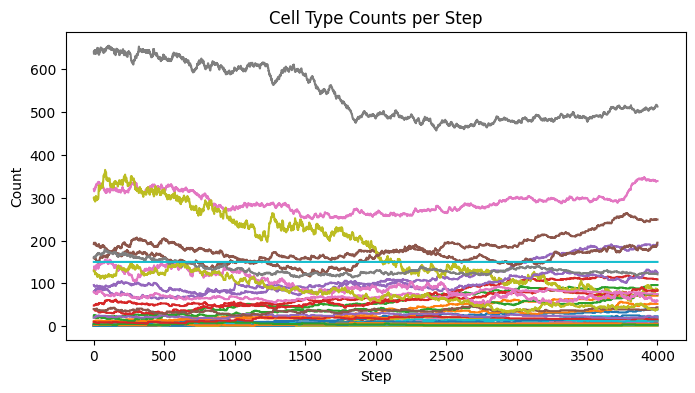

In [196]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=counts, x='step', y='count', hue='cell_type', legend=False, palette='tab10')
plt.title('Cell Type Counts per Step')
plt.xlabel('Step')
plt.ylabel('Count')
plt.show()

In [91]:
counts[counts.step == counts.step.max()]


,step,cell_type,count
74647,2000,17,528
74648,2000,16,295
74649,2000,15,200
74650,2000,40,150
74651,2000,18,149
74652,2000,14,140
74653,2000,25,137
74654,2000,38,131
74655,2000,13,104
74656,2000,24,88


In [197]:
df.groupby('step').count()

,cell_type,x,y,dx,dy,clone_id,vessel_neighbourhood,status,cell_id
step,,,,,,,,,
0,2707,2707,2707,2707,2707,2707,2707,2707,2707
1,2708,2708,2708,2708,2708,2708,2708,2708,2708
2,2704,2704,2704,2704,2704,2704,2704,2704,2704
3,2709,2709,2709,2709,2709,2709,2709,2709,2709
4,2709,2709,2709,2709,2709,2709,2709,2709,2709
...,...,...,...,...,...,...,...,...,...
3996,2868,2868,2868,2868,2868,2868,2868,2868,2868
3997,2869,2869,2869,2869,2869,2869,2869,2869,2869
3998,2871,2871,2871,2871,2871,2871,2871,2871,2871


In [198]:
def get_hematopoietic_cells(df, step_number):    
    step_data = df[df['step'] == step_number].copy()

    step_data['cell_type_e'] = step_data['cell_type'].apply(lambda x: CellType(x).name)
    step_data = step_data[step_data['cell_type'] != CellType.STROMA]
    return step_data

In [141]:
def hspc_mature_distances(df, step_number): 
    step_data = get_hematopoietic_cells(df, step_number)
    step_hspcs = step_data[step_data['cell_type'].isin(HSC + MPP + RPP)][['x', 'y', 'cell_type', 'cell_type_e']]
    step_mature_cells = step_data[~step_data['cell_type'].isin(HSC + MPP + RPP)][['x', 'y', 'cell_type', 'cell_type_e']]
    assert len(step_data) == len(step_hspcs) + len(step_mature_cells)

    coords_mature = step_mature_cells[['x', 'y']].values
    coords_hspcs = step_hspcs[['x', 'y']].values

    dists = cdist(coords_hspcs, coords_mature)
    return dists


(14, 2619)


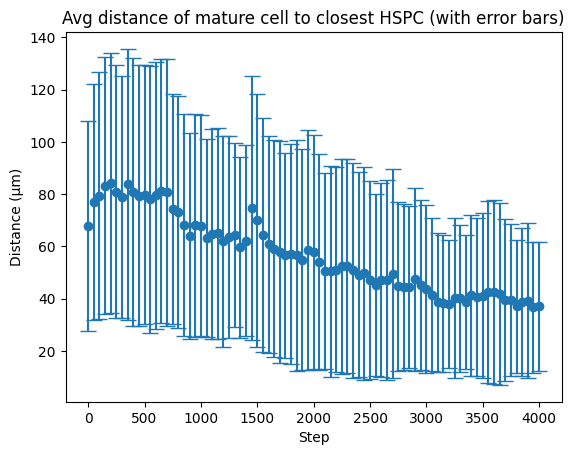

In [200]:
step_nums = list(range(0, 4001, 50))

bars, errors = [], []
for step_num in step_nums:
    dists = hspc_mature_distances(df, step_num)
    # print(dists.shape)
    min_dist_from_mature_to_hspc = np.min(dists, axis=0)
    bars.append(np.mean(min_dist_from_mature_to_hspc))
    errors.append(np.std(min_dist_from_mature_to_hspc))

    # plt.hist(min_dist_from_mature_to_hspc, bins=100)

plt.errorbar(step_nums, bars, yerr=errors, capsize=6, fmt='o')
plt.ylabel('Distance (µm)')
plt.title('Avg distance of mature cell to closest HSPC (with error bars)')
plt.xlabel('Step')
plt.show()


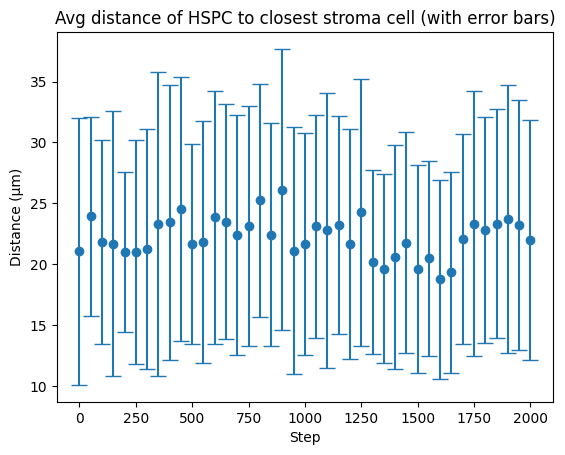

In [202]:

step_nums = list(range(0, 2001, 50))

bars, errors = [], []

for step_num in step_nums:
    step_data = df[df['step'] == step_num].copy()

    # HSPC to stroma cell distance
    step_hspcs = step_data[step_data['cell_type'].isin(HSC + MPP + RPP)]
    step_stroma = step_data[step_data['cell_type'] == CellType.STROMA]

    dists = cdist(step_hspcs[['x', 'y']], step_stroma[['x', 'y']])
    assert dists.shape == (len(step_hspcs), len(step_stroma))
    min_dist_from_hspc_to_stroma = np.min(dists, axis=1)
    bars.append(np.mean(min_dist_from_hspc_to_stroma))
    errors.append(np.std(min_dist_from_hspc_to_stroma))


plt.errorbar(step_nums, bars, yerr=errors, capsize=6, fmt='o')
plt.ylabel('Distance (µm)')
plt.title('Avg distance of HSPC to closest stroma cell (with error bars)')
plt.xlabel('Step')
plt.show()

